In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow as tf

from keras import layers
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.datasets import fashion_mnist
from keras.callbacks import History, Callback

In [3]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.clf()
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

In [4]:
def plot_precision_recall(history):
    precision_values = [history.history[f'precision_class_{i}'][-1] for i in range(10)]
    recall_values = [history.history[f'recall_class_{i}'][-1] for i in range(10)]

    classes = [str(i) for i in range(10)]
    width = 0.35
    x = range(len(classes))

    plt.figure(figsize=(12, 6))

    plt.bar(x, precision_values, width, label='Precision')
    plt.bar([i + width for i in x], recall_values, width, label='Recall')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall for Each Class')
    plt.xticks([i + width/2 for i in x], classes)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.grid(axis='y', linestyle='--')

    plt.show()

In [5]:
clothing_classes = 10
n_hidden_1 = 64
n_hidden_2 = 128
n_hidden_3 = 256
epochs = 10

In [6]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

train_data, test_data = train_data / 255., test_data / 255.

train_labels_one_hot = to_categorical(train_labels, num_classes=clothing_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=clothing_classes)

In [7]:
precision_per_class = [Precision(class_id=i, name=f'precision_class_{i}') for i in range(clothing_classes)]
recall_per_class = [Recall(class_id=i, name=f'recall_class_{i}') for i in range(clothing_classes)]

all_metrics = ['accuracy'] + precision_per_class + recall_per_class

In [8]:
class MyFilterModelMP(keras_tuner.HyperModel):
  def build(self, hp):
    model = Sequential([
      Conv2D(
          filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
          kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
          activation='relu',
          input_shape=(28,28,1)
      ),
      MaxPooling2D((2, 2)),
      Conv2D(
          filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
          kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
          activation='relu'
      ),
      Flatten(),
      Dense(
          units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
          activation='relu'
      ),
      Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='categorical_crossentropy',
                metrics=all_metrics)

    return model

  def fit(self, hp, model, x, y, validation_data, **kwargs):
    if hp.Boolean("normalize"):
      x = layers.Normalization()(x)
    return model.fit(
      x,
      y,
      validation_data=validation_data,
      shuffle=hp.Boolean("shuffle"),
      **kwargs,)

In [9]:
tuner = keras_tuner.RandomSearch(
    MyFilterModelMP(),
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
)

In [10]:
tuner.search(train_data,
             train_labels_one_hot,
             epochs=5,
             validation_data=(test_data, test_labels_one_hot),
             batch_size=32)

Trial 5 Complete [00h 02m 20s]
val_accuracy: 0.9157000184059143

Best val_accuracy So Far: 0.9157000184059143
Total elapsed time: 00h 09m 36s


In [11]:
filtermodel = MyFilterModelMP()
best_hp = tuner.get_best_hyperparameters()[0]
model_filter_ = filtermodel.build(best_hp)
history = filtermodel.fit(best_hp,
                        model_filter_,
                        train_data,
                        train_labels_one_hot,
                        validation_data=(test_data, test_labels_one_hot),
                        epochs=5,
                        batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 30s 15ms/step - loss: 0.3878 - accuracy: 0.8599 - precision_class_0: 0.8371 - precision_class_1: 0.9832 - precision_class_2: 0.8188 - precision_class_3: 0.9014 - precision_class_4: 0.8040 - precision_class_5: 0.9696 - precision_class_6: 0.7466 - precision_class_7: 0.9292 - precision_class_8: 0.9769 - precision_class_9: 0.9537 - recall_class_0: 0.8054 - recall_class_1: 0.9557 - recall_class_2: 0.7564 - recall_class_3: 0.8580 - recall_class_4: 0.7476 - recall_class_5: 0.9399 - recall_class_6: 0.5350 - recall_class_7: 0.9301 - recall_class_8: 0.9497 - recall_class_9: 0.9450 - val_loss: 0.2908 - val_accuracy: 0.8953 - val_precision_class_0: 0.8866 - val_precision_class_1: 0.9959 - val_precision_class_2: 0.8890 - val_precision_class_3: 0.8824 - val_precision_class_4: 0.8247 - val_precision_class_5: 0.9808 - val_precision_class_6: 0.7497 - val_precision_class_7: 0.9680 - val_precision_class_8: 0.9958 - val_precision_class_9: 0.9466 - val

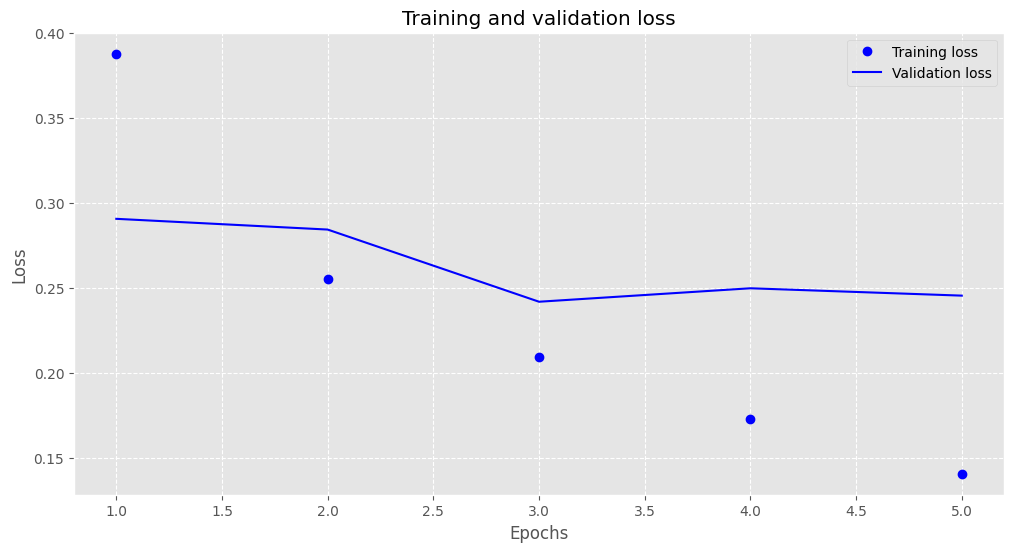

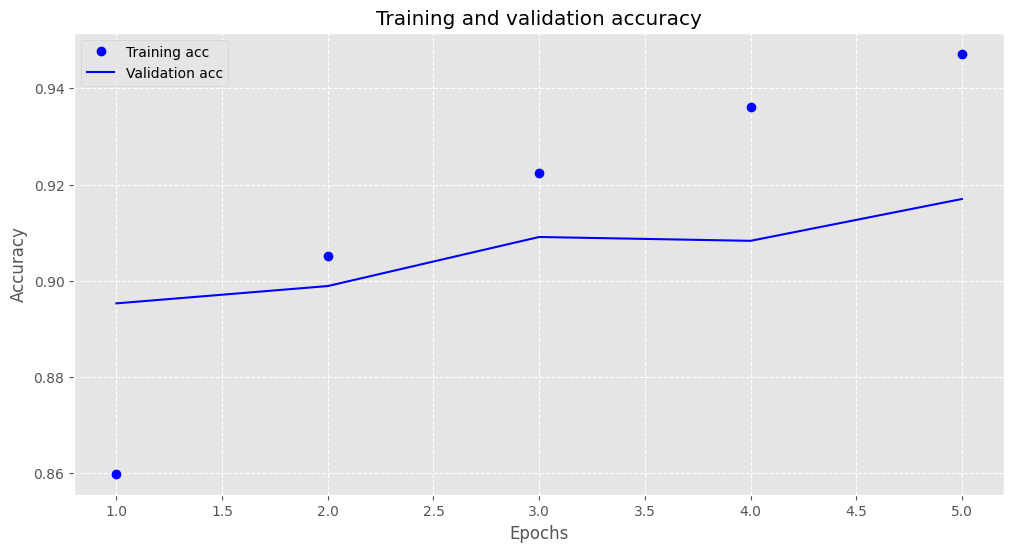

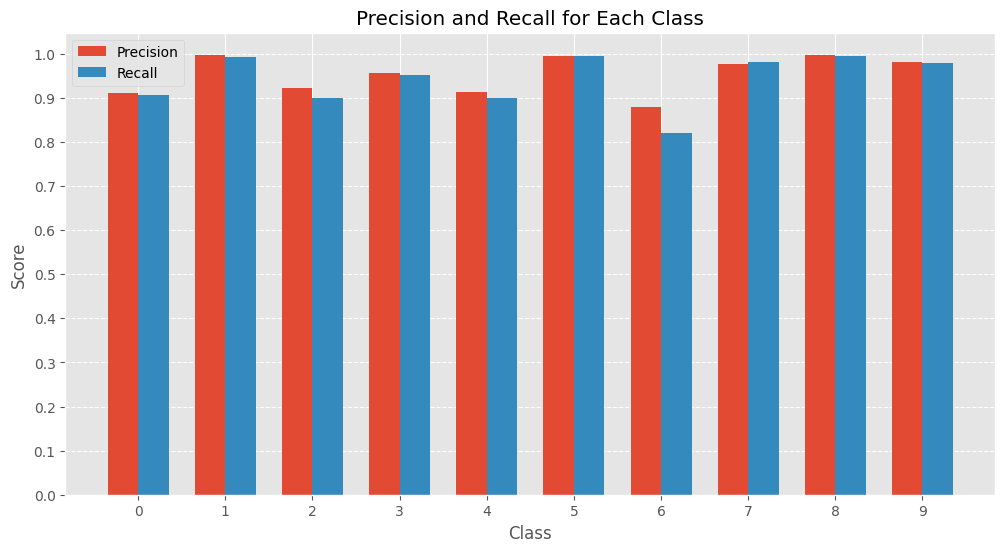

In [12]:
plot_history(history)
plot_precision_recall(history)

In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.1,
)

train_generator = datagen.flow(train_data.reshape(-1, 28, 28, 1), train_labels_one_hot, batch_size=32)

In [14]:
filtermodel = MyFilterModelMP()
best_hp = tuner.get_best_hyperparameters()[0]
model_filter = filtermodel.build(best_hp)
history = model_filter.fit(
    train_generator,
    steps_per_epoch=100,
    validation_data=(test_data.reshape(-1, 28, 28, 1), test_labels_one_hot),
    validation_steps=50,
    epochs=100,
    batch_size=32
)

Epoch 1/100
100/100 [==============================] - 5s 27ms/step - loss: 0.9856 - accuracy: 0.6375 - precision_class_0: 0.8833 - precision_class_1: 0.9775 - precision_class_2: 0.8585 - precision_class_3: 0.8991 - precision_class_4: 0.8298 - precision_class_5: 0.9527 - precision_class_6: 0.7351 - precision_class_7: 0.9241 - precision_class_8: 0.9819 - precision_class_9: 0.9680 - recall_class_0: 0.7509 - recall_class_1: 0.9234 - recall_class_2: 0.6765 - recall_class_3: 0.8332 - recall_class_4: 0.7427 - recall_class_5: 0.9174 - recall_class_6: 0.6211 - recall_class_7: 0.8927 - recall_class_8: 0.9005 - recall_class_9: 0.8945 - val_loss: 0.6018 - val_accuracy: 0.7656 - val_precision_class_0: 0.7834 - val_precision_class_1: 0.9868 - val_precision_class_2: 0.7579 - val_precision_class_3: 0.9008 - val_precision_class_4: 0.7895 - val_precision_class_5: 0.9161 - val_precision_class_6: 0.3016 - val_precision_class_7: 0.8650 - val_precision_class_8: 0.9773 - val_precision_class_9: 0.9643 - val_

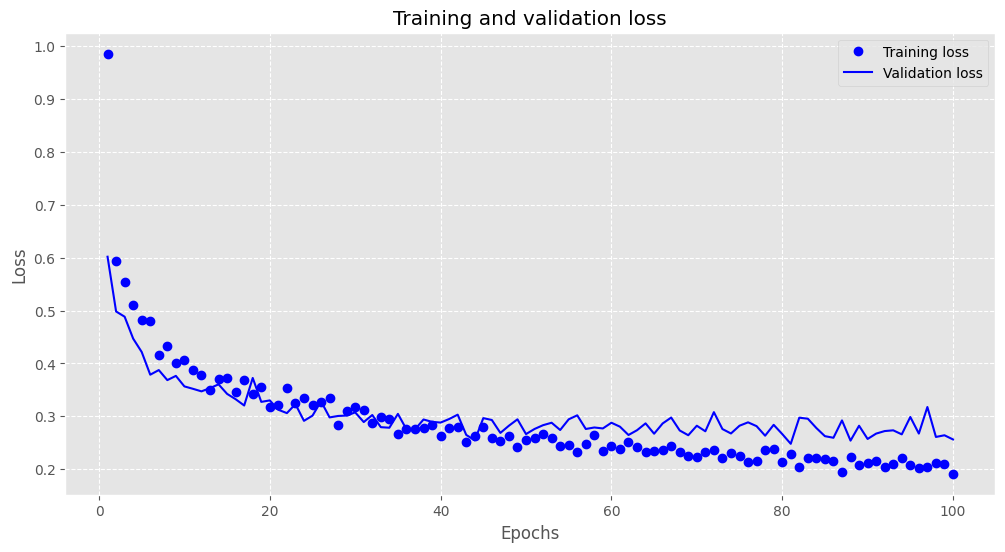

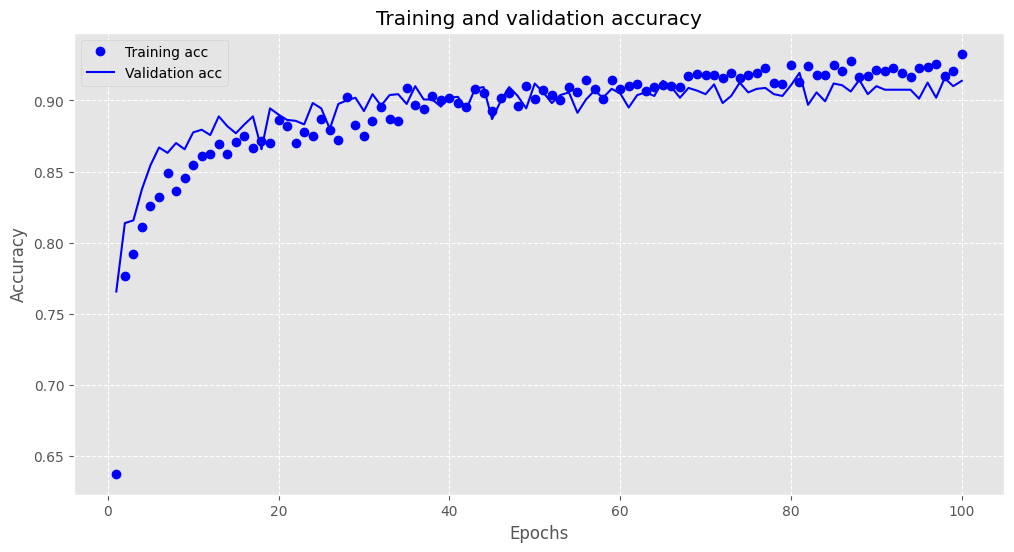

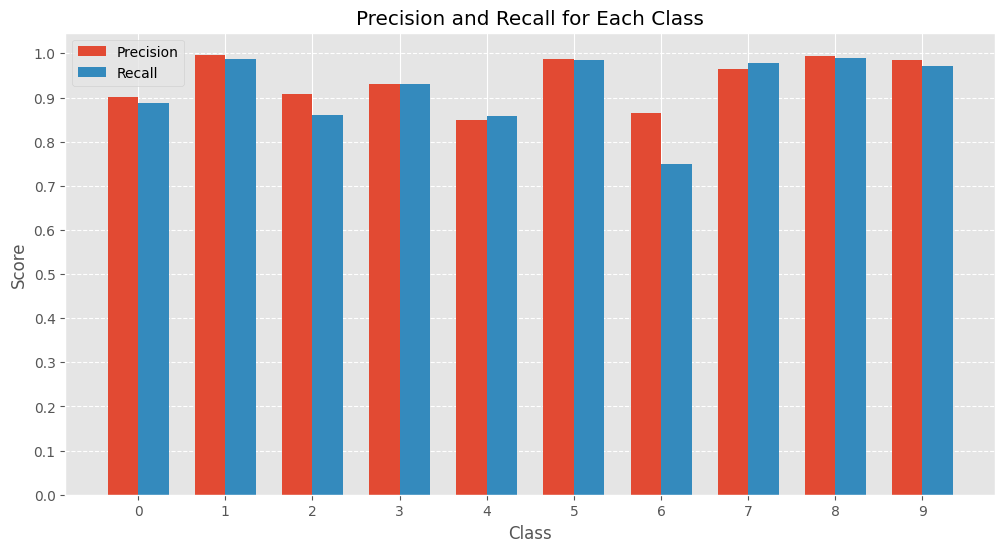

In [15]:
plot_history(history)
plot_precision_recall(history)

In [16]:
results = model_filter.evaluate(test_data.reshape(-1, 28, 28, 1), test_labels_one_hot)
print(results)

313/313 [==============================] - 1s 5ms/step - loss: 0.2449 - accuracy: 0.9124 - precision_class_0: 0.8782 - precision_class_1: 0.9969 - precision_class_2: 0.8698 - precision_class_3: 0.9303 - precision_class_4: 0.8775 - precision_class_5: 0.9831 - precision_class_6: 0.7513 - precision_class_7: 0.9550 - precision_class_8: 0.9899 - precision_class_9: 0.9856 - recall_class_0: 0.8510 - recall_class_1: 0.9800 - recall_class_2: 0.8420 - recall_class_3: 0.9070 - recall_class_4: 0.8380 - recall_class_5: 0.9890 - recall_class_6: 0.7400 - recall_class_7: 0.9770 - recall_class_8: 0.9810 - recall_class_9: 0.9600
[0.24490153789520264, 0.9124000072479248, 0.8782249689102173, 0.9969481229782104, 0.8698347210884094, 0.9302564263343811, 0.8774868845939636, 0.9831013679504395, 0.7512690424919128, 0.9550341963768005, 0.9899091720581055, 0.9856262803077698, 0.8510000109672546, 0.9800000190734863, 0.8420000076293945, 0.9070000052452087, 0.8379999995231628, 0.9890000224113464, 0.7400000095367432,

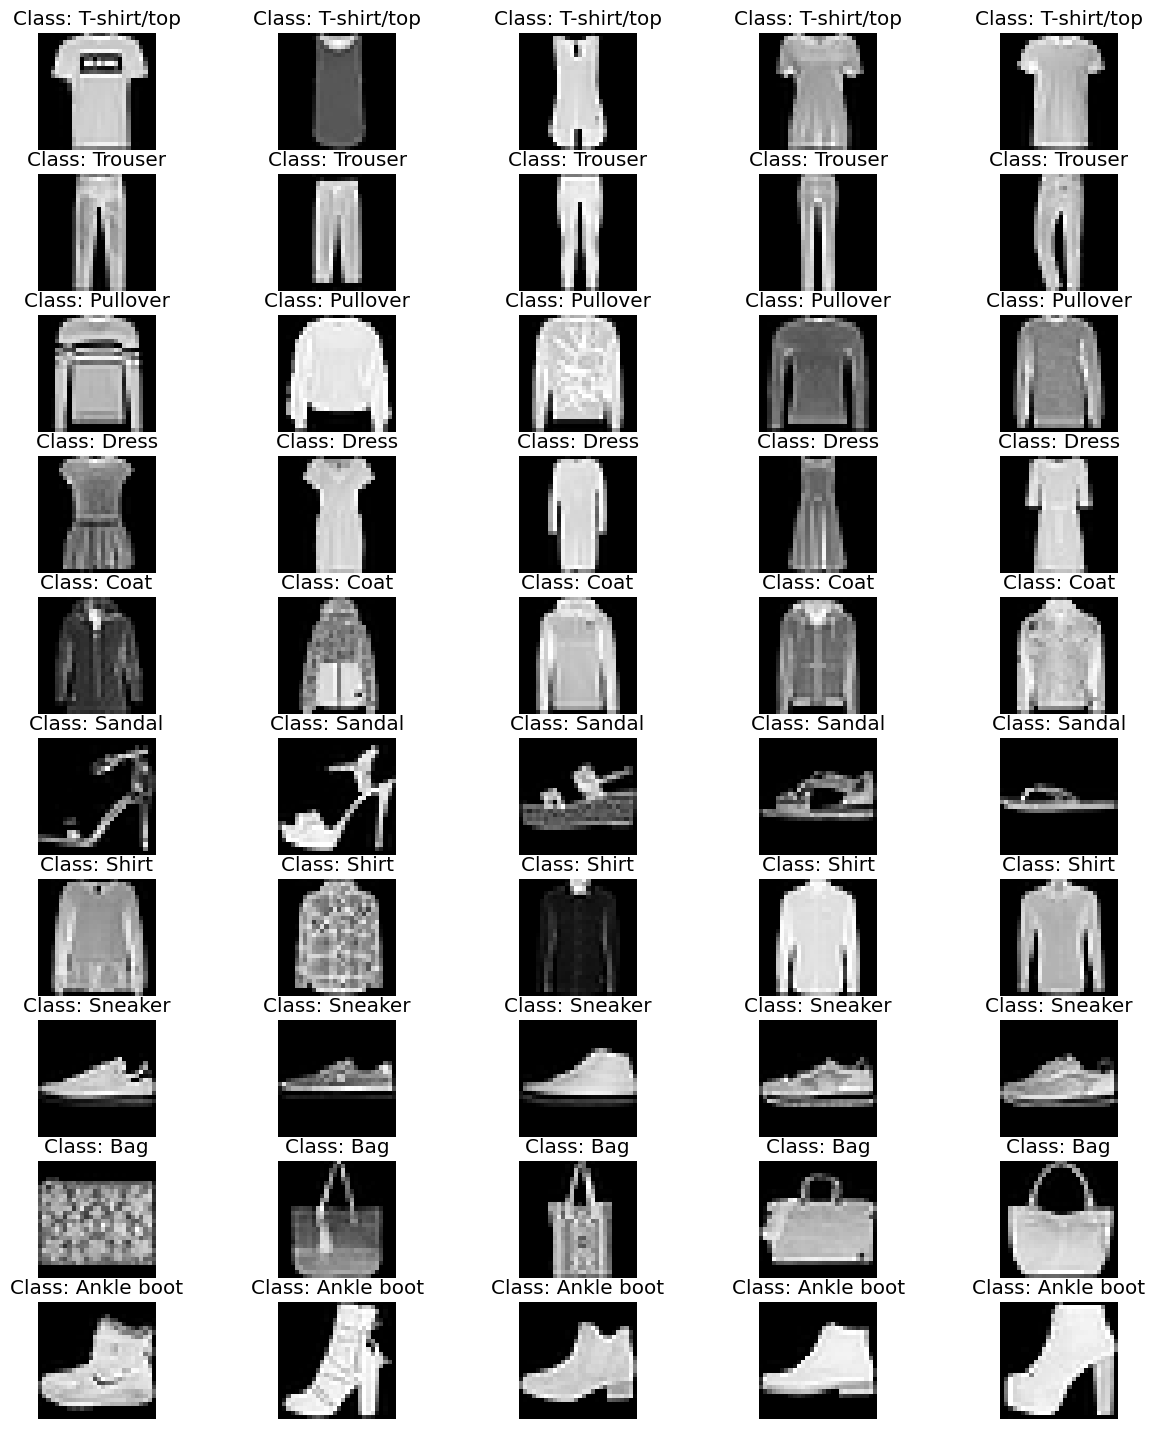

In [23]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(15, 18))

for i in range(len(class_names)):
    class_indices = np.where(train_labels == i)[0][:5]
    for j, idx in enumerate(class_indices):
        plt.subplot(len(class_names), 5, i * 5 + j + 1)
        plt.imshow(train_data[idx], cmap='gray')
        plt.title(f"Class: {class_names[i]}")
        plt.axis('off')

plt.show()

# Висновки:

У попередньому ДЗ я зробив висновой щоб збільшити True Positive для деяких класів треба збільшити датасет для них. Але збільшивши датасет за допомогою невеликого кута та зуму картинки ТР для цих класів не змінився. Подивившись на сам датасет можна зрозуміти чому, томущо для класів (0,2,3,4,6) в них багато спільних ознак.